In [485]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline : 18 octobre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

Balthazar Neveu

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [ ]:
!pip install interactive-pipe

In [2]:

import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd
from scipy.signal import spectrogram
# %matplotlib notebook
from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interact
from interactive_pipe.data_objects.image import Image
import numpy as np 
import matplotlib.pylab as plt 

from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interactive, interactive_pipeline
from numpy.fft import fft,fftfreq,fftshift
from scipy.ndimage import gaussian_filter

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [3]:
rate, signal = scipy.io.wavfile.read("Voice.wav")
# rate, signal = scipy.io.wavfile.read("baby_maman_papa.wav")
ipd.Audio(signal, rate=rate)
# signal has 16 bits

<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
</div>

# Visualisation de la forme d'onde et de la densité spectrale


On peut utiliser le code suivant basé sur la [librairie interactive_pipe](https://github.com/balthazarneveu/interactive_pipe) (que je maintiens)  afin de parcourir le signal.


## Voix cassée masculine

![dsp](illustrations/power_spectrum_density_broken_man_voice_44kHz.png)

- On observe des fréquences autour de 100Hz puis 200, 300, 400, 500 et 600Hz. 
- La fréquence contenant le plus de fréquence devrait naturellement être la plus faible/grave parmis ces harmoniques. 
- Il se trouve que j'ai la voix bien cassée en ce moment, ce qui rend l'analyse plus difficile.


## Voix de bébé
La voix est bien plus aïgue avec un pitch autour de 500Hz. La seconde harmonique apparaît autour de 1kHz. La fréquence fondamentale est celle qui a le plus de puissance.


![dsp](illustrations/baby_voice.png)

In [4]:
from interactive_pipe.helper import _private
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.


def load_signal(path: str, global_params={}) -> np.array:
    rate, signal = scipy.io.wavfile.read(path)
    global_params["sampling_rate"] = rate
    return signal


@interactive(
    time_selection=(50., [0., 100.], "selected time [%]"), 
    window=(1., [0.01, 3.], "window size [s]")
)
def trim_signal(
    signal,
    time_selection: float=0.,
    window: float = 0.3,
    global_params={}
):
    rate = global_params["sampling_rate"]
    full_time = np.arange(len(signal))/rate
    full_signal = signal/(2.**15-1) # assume 16bits signed
    temporal_signal_length = len(signal)/rate
    time_center  = time_selection/100.*temporal_signal_length
    time_start = max(0,time_center-window/2.)
    time_end = min(temporal_signal_length, time_center+window/2.)
    index_start, index_end = int(time_start*rate), min(int(time_end*rate), len(signal))
    time = full_time[index_start:index_end] 
    current_signal = full_signal[index_start:index_end]
    global_params["time_start"] = time_start
    global_params["time_end"] = time_end 
    return time, current_signal



def visualize_signal(timeline, signal, global_params={}):
    curve = Curve(
        [
            (timeline, signal, "k-")
        ],
        grid=True,
        title=f"signal {global_params['time_start']:.2f} {global_params['time_end']:.2f}",
        xlim=(timeline[0], timeline[-1]),
        ylim=(-1., 1.),
        xlabel="t[s]",
        ylabel="Audio amplitude"
    )
    return curve


def visualize_fourier(frequencies, fourier_coefficients, global_params={}):
    freq_axis = frequencies[len(frequencies)//2:]
    amplitude_axis = np.abs(fourier_coefficients[len(frequencies)//2:])
    curve = Curve(
        [
            (freq_axis, amplitude_axis, "b-")
        ],
        grid=True,
        xlabel="f[Hz]",
        xlim=(0., 800.)
    )
    return curve

def compute_spectrum(x, global_params={}):
    fs = global_params["sampling_rate"]
    X= fft(x) / np.sqrt(len(x))
    f= fftfreq(len(x),d=1/fs)
    X_ordered = fftshift(X)
    f_ordered= fftshift(f)
    return f_ordered, np.abs(X_ordered)**2. #* fs

@interactive_pipeline(gui="nb", size=(10, 5))
def audio_pipeline(audio_path):
    full_audio_signal = load_signal(audio_path)
    trimmed_timeline, trimmed_audio = trim_signal(full_audio_signal)
    sig_viz = visualize_signal(trimmed_timeline, trimmed_audio)
    freq, ampl = compute_spectrum(trimmed_audio)
    spectrum = visualize_fourier(freq, ampl)
    return sig_viz, spectrum

audio_pipeline("Voice.wav")

interactive(children=(FloatSlider(value=50.0, description='selected time [%]', layout=Layout(width='500px'), s…

# Spectrogramme

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

# Spectrogramme du signal et récupération du pitch.

On peut récupérer la fréquence fondamentale (pitch) à l'aide d'un argmax sur le spectrogramme.
Concrètement, on cherche l'arg-maximum suivant les colonnes du spectrogramme ce qui permet d'obtenir la courbe rouge superposée au spectrogramme. Un petit **détecteur de silence** permet d'enlever les parties inutiles. 
On aurait évidemment envie de contraindre l'espace de recherche mais malheureusement il faut évidémment éviter de faire cela si on souhaite estimer le pitch des hommes & des femmes.

- Augmenter la largeur de la fenêtre a tendance à flouter horizontalement. **Utiliser des fenêtres de 100ms** permet d'obtenir un compromis correct (des spectrogrammes assez lisses et 5 échantillons de fréquence par secondes) et limite des détections d'autres harmoniques..
- Avec une fenêtre de 30ms, on a des fréquences assez quantifiées (~ pas de 25 à 50Hz un peu trop grossier à mon goût). 
- Ci dessous, on pourra trouver un petit widget qui permet de "tuner" les paramètes au mieux. 

Sur la voix de Mathilde qui a eu la gentillesse de me partager son échantillon. Pas de problèmes. Cela se passe correctement sur la voix de mon bébé aussi.
En revanche sur ma voix cassé, très difficile de récupérer un signal fiable. M'étant acharné sur le problème.


-----

![pitch_analyzis_woman](illustrations/pitch_analyzis_woman.png)

-----


In [143]:
from ipywidgets import interact as interact_widg
from ipywidgets import fixed, FloatSlider

def plot_spectrogram(signal, sampling_rate, window_time=0.03, overlap_ratio=0.2, silence_threshold=0.005, return_values=False):
    window = "hann"    
    # Curve([(np.arange(len(selected_window))/rate, selected_window)], xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))
    nperseg = int(window_time*sampling_rate)
    f, t, Sxx = spectrogram(
        signal,
        fs=rate,
        window=window,
        nperseg=nperseg,
        noverlap=int(overlap_ratio*nperseg),
        scaling="spectrum"
        # nperseg=1024
    )
    Sxx = np.clip(Sxx, 1.E-15, None)
    
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')

    sliding_argmax = np.argmax(Sxx, axis=0)
    energy = np.array([Sxx[amax, idx] for idx, amax in enumerate(sliding_argmax)])
    silence_flag = np.sqrt(energy)<silence_threshold
    
    pitch = f[sliding_argmax]
    pitch[silence_flag] = np.NaN
    
    plt.plot(t, pitch, "r-", label="Pitch tracking")
    plt.title(f"Log-Spectrogram window={window_time*1000.:.2f}ms - pitch={np.nanmedian(pitch):.1f}Hz")
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # plt.ylim(0., 1000.)
    plt.ylim(0., 800.)
    
    plt.legend()

    if return_values:
        time_axis = np.arange(len(signal))/sampling_rate
        current_freq = np.interp(time_axis, xp=t, fp=f[sliding_argmax])
        energy = np.array([Sxx[amax, idx] for idx, amax in enumerate(sliding_argmax)])
        energy[silence_flag] = 0. #np.NaN # DISCARD SILENCE
        current_amplitude = np.interp(time_axis, xp=t, fp=energy)
        current_amplitude = np.sqrt(current_amplitude)
        reconstructed_pitch_only = current_amplitude*np.sin(2.*np.pi*current_freq*time_axis)
        return time_axis, reconstructed_pitch_only

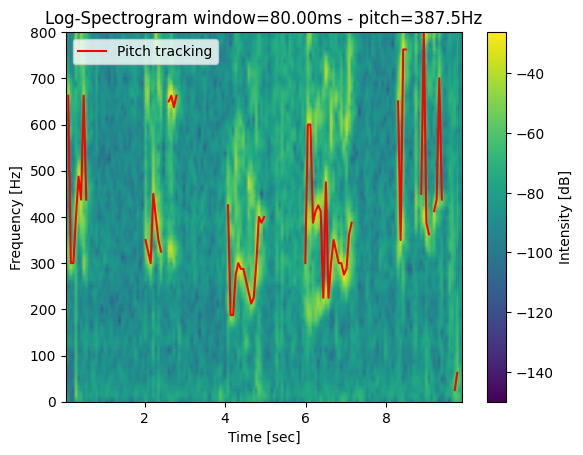

In [148]:
# rate, signal = scipy.io.wavfile.read("Voice.wav")
rate, signal = scipy.io.wavfile.read("baby_maman_papa.wav")
time_axis, reconstructed_pitch_only = plot_spectrogram(signal[:rate*10]/(2.**15-1.), rate, window_time=0.08, overlap_ratio=0.2, silence_threshold=0.001, return_values=True)
# print("RECONSTRUCTED PURE PITCH , be careful with your ears")
# ipd.Audio(np.round(reconstructed_pitch_only*(2.**15-1)).astype(np.int16), rate=rate)

In [141]:
print("ORIGINAL SIGNAL")
ipd.Audio(np.round(selected_window*(2.**15-1)).astype(np.int16), rate=rate)

ORIGINAL SIGNAL


## Interactive tuning 

In [142]:
selected_window = signal/(2**15-1)
interact_widg(
    plot_spectrogram,
    signal=fixed(selected_window),
    sampling_rate=fixed(rate),
    window_time=FloatSlider(min=0.005, max=0.5, value=0.2, step=0.001),
    overlap_ratio=FloatSlider(min=0., max=0.95, value=0.2, step=0.01),
    silence_threshold=FloatSlider(min=0., max=0.01, value=0.005, step=0.00001),
    return_values = fixed(False)
);

interactive(children=(FloatSlider(value=0.2, description='window_time', max=0.5, min=0.005, step=0.001), Float…

# Test unitaire
- Avec le code ci dessous, on introduit une sinusoïde pure afin de vérifier que le ptich est récupéré correctement.
- On peut reconstruire un pure sinusoïde à l'aide du pitch prédit pour essayer de retrouver une ressemblance. Attention au tympans à l'écoute...

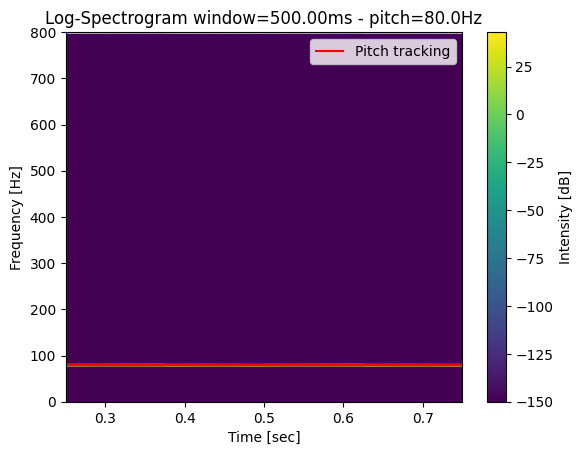

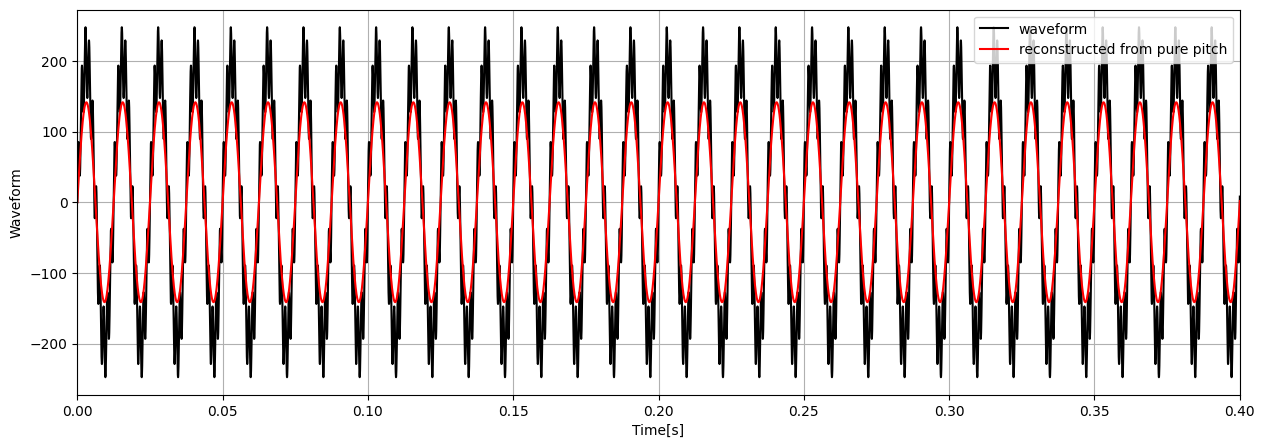

In [123]:
time_stamps = np.arange(rate)/rate
freq = 80.
sine_wave = 200.*np.sin(2.*np.pi*freq*time_stamps) + 50.*np.sin(2.*np.pi*freq*10*time_stamps)
selected_window = sine_wave
time_axis, reconstructed_pitch_only = plot_spectrogram(selected_window, rate, window_time=0.5, overlap_ratio=0.5, return_values=True)
Curve([
        (time_axis, selected_window, "k-", "waveform",),
        (time_axis, reconstructed_pitch_only, "r-", "reconstructed from pure pitch")
        ],
        xlabel="Time[s]", xlim=(0., 0.4), ylabel="Waveform", grid=True).show(figsize=(15, 5)
)


### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Commentez.
    </div>

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [151]:
donnees = np.load('signaux_impulsions.npz')
list(donnees.keys())
signaux = donnees['data']
labels = donnees['labels']
signaux.shape, labels.shape

((10000, 1000), (10000,))

## Première exploration des données.
L'écart type du bruit étant tiré au hasard, on remarque en regardant étudiant les données qu'il va être difficile d'utiliser des statistiques globales pour distinguer les impulsions du bruit. Ceci aurait été moins vrai si le bruit avait été d'écart type connu ou figé.
Contentons nous d'une statistique globale!

In [161]:
from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interact


def explore_curve(sample_index=0):
    current_signal = signaux[sample_index, :]
    time = np.arange(len(current_signal))
    squared_signal = current_signal**2
    energy_cum = np.cumsum(squared_signal)
    detect = labels[sample_index] == 1
    std_dev = np.std(current_signal)
    moment_4 = np.std(squared_signal)
    curve = Curve(
        [(time, current_signal, "g-" if detect else "r--")],
        grid=True,
        title=f"signal {sample_index}, {detect} std {std_dev:.2f} m4 {moment_4:.2f}",
        ylim=(-2., 2.)
    )
    curve_cum = Curve(
        [(time, energy_cum/energy_cum[-1], "b-"), (time, time/time[-1], "k--")],
        grid=True,
        title=f"signal {sample_index}, {int(labels[sample_index])}",
        ylim=(0., 1.)
    )
    return curve, curve_cum

interact(sample_index=(0, 10000-1, 10))(explore_curve)
# curve.show()

interactive(children=(IntSlider(value=4999, description='sample_index', layout=Layout(width='500px'), max=9999…

<function __main__.explore_curve(sample_index=0)>

## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

In [301]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float = 0.) -> bool:
    std = np.std(signal, axis=1)
    m4 = np.std(signal**2, axis=1)
    return np.logical_or(std**2>0.5, (m4/std**2)>1.6+seuil)

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [302]:
# proposal for a quick fit, (first time I actually use scikit learn, this is a premiere for me :-) ... i prefer my manual heuristic so far
from sklearn.linear_model import LogisticRegression
train_data = np.array([np.std(signaux, axis=1), np.std(signaux**2, axis=1)]).T
model = LogisticRegression()
model.fit(train_data, labels)
labels_logistic_reg = model.predict(train_data)

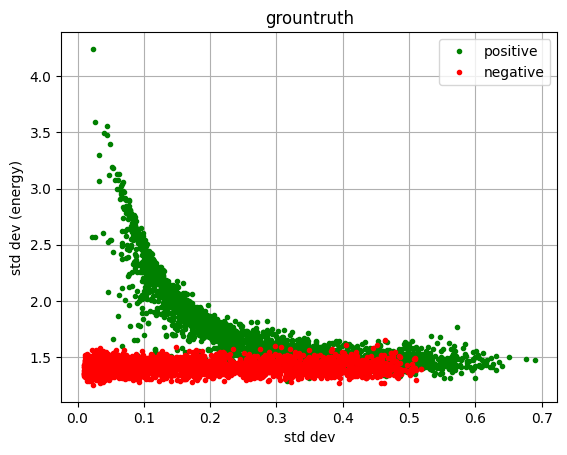

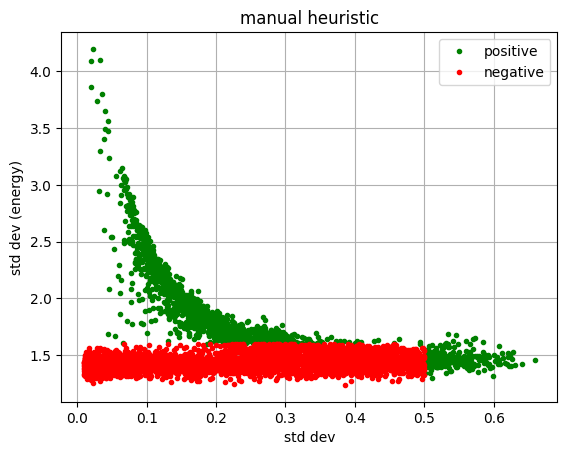

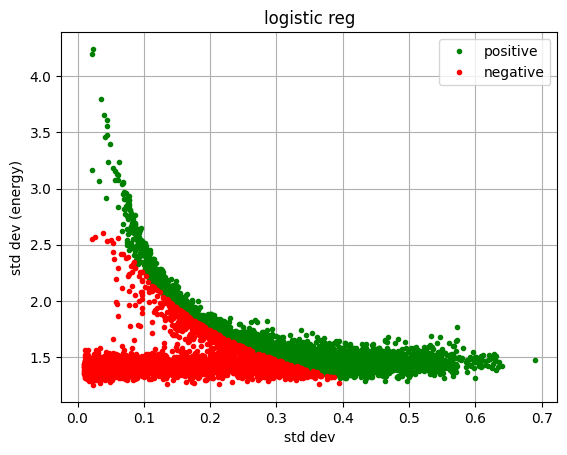

In [276]:
for current_labels, title in [
    (labels, "grountruth"),
    (contient_impulsion_energie(signaux), "manual heuristic"),
    (labels_logistic_reg, "logistic reg")
]: #Grountruth / Empirical manual prediction
    positive_signals = np.array([sig for idx, sig in enumerate(signaux) if current_labels[idx]])
    negative_signals = np.array([sig for idx, sig in enumerate(signaux) if not current_labels[idx]])
    # positive_signals.shape, negative_signals.shape
    for sigs, col, label in [(positive_signals, "g.", "positive"), (negative_signals, "r.", "negative")]:
        metric_2 = np.std(sigs[::2], axis=1)**2
        metric_4 = np.std(sigs[::2]**2, axis=1)/metric_2
        plt.plot(metric_2, metric_4, col, label=label)
    plt.xlabel("std dev")
    plt.ylabel("std dev (energy)")
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()


<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [340]:
def evaluate_prediction(prediction, grountruth):
    vp = np.logical_and(prediction==1, grountruth==1).sum()
    fp = np.logical_and(prediction==1, grountruth==0).sum()
    vn = np.logical_and(prediction==0, grountruth==0).sum()
    fn = np.logical_and(prediction==0, grountruth==1).sum()
    assert vp + fp +  vn + fn == signaux.shape[0]
    return vp, fp, vn, fn

In [341]:
prediction = contient_impulsion_energie(signaux)
grountruth = np.array(labels)
vp, fp, vn, fn = evaluate_prediction(prediction, grountruth)
print(f"{vp=}, {fp=}, {vn=}, {fn=}")

vp=3132, fp=31, vn=4965, fn=1872


## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


# Spectrogram based detection - exploration et critère
- Le bruit blanc se traduit par un "fond bruit" sur le spectre (et a fortiori dans le spectrogramme). 
- Les impulsions sont alors des "rectangles" superposés (limités dans le temps, à une fréquence spécifique).
Afin de les détecter, on aurait envie de détecter des rectangles. Aussi simple que ceci puisse paraître, une courte phase exploratoire a abouti à une solution qui reste simple (mais a l'air efficace).


On floute avec un filtre Gaussien 2D isotrope de taille assez élevé, le spectrogramme puis on calcule un critère de maximum divisé par la moyenne. On floute le contour mais on enlève une partie du bruit. (Un filtre bilatéral ou un NL means auraient sûrement été plus aproprié).
Je n'exploite malheureusement pas la structure "rectangulaire" pourtant si caractéristique à l'oeil (mes courts essaies avec l'utilisation de filtres de Sobel n'ont pas vraiment abouti).


In [ ]:
# contient_impulsion_spectrogramme
# def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
def spectrogram_detection_heuristic(signal: np.ndarray, seuil: float = 1.4138) -> bool:
    """1.4138 is the best threshold"""
    criterion = []
    for index in range(signal.shape[0]):
        f, t, Sxx = spectrogram(
            signal[index, :],
            fs=1.,
            window="hann",
            nperseg=20,
            noverlap=0,
            scaling="spectrum"
        )
        Sxx = np.clip(Sxx, 1.E-15, None)
        Sxx_g = gaussian_filter(Sxx, sigma=5)
        ratio = np.max(Sxx_g) / np.mean(Sxx_g)
        crit = ratio > seuil
        criterion.append(crit)
    return np.array(criterion)

labels_spectro = spectrogram_detection_heuristic(posi, seuil=3.)

In [460]:
# Exploratory phase... not so easy to detect rectangles in the middle of the noise... not so satisfied by my final solution though.
def check_spectrogram(index=31):
    f, t, Sxx = spectrogram(
        signaux[index,:],
        fs=1.,
        window="hann",
        nperseg=20,
        noverlap=0,
        scaling="spectrum"
    )
    Sxx = np.clip(Sxx, 1.E-15, None)
    # print(np.argmax(Sxx))
    # gaussian_filter1d(max_over_min, sigma=5)
    # max_over_min = np.max(Sxx, axis=0)/np.min(Sxx)
    # max_over_min = gaussian_filter1d(max_over_min, sigma=5)
    # plt.plot(max_over_min)
    # plt.plot(max_over_min[1:] - max_over_min[:1]) 
    # abs_grad = np.abs(sobel(Sxx, axis=0))+np.abs(sobel(Sxx, axis=1))
    # plt.imshow(abs_grad/np.std(Sxx))

    # plt.plot(np.std(Sxx, axis=0)/np.std(Sxx))
    # plt.imshow(Sxx/np.std(Sxx)>2.)
    plt.imshow(gaussian_filter(Sxx, sigma=5))
    plt.show()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
interact_widg(check_spectrogram, index=31)

interactive(children=(IntSlider(value=31, description='index', max=93, min=-31), Output()), _dom_classes=('wid…

<function __main__.check_spectrogram(index=31)>

<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{VP}{VP + FP}$$
et le rappel comme:
$$ \frac{VP}{VP +FN} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

In [356]:
def get_precision_recall(vp, fp, vn, fn):
    precision = vp/(vp+fp)
    rappel = vp/(vp+fn)
    return precision, rappel

get_precision_recall(100, 0, 100, 0) # meilleur cas, que des vrais positifs et des vrais négatifs ... en haut à droite
get_precision_recall(0, 100, 0, 100) # pire cas, ni vrai positif ni vrai négatif... en bas à gauche du graphe

(0.0, 0.0)

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

In [344]:
def get_precision_recall_from_labels(prediction, grountruth):
    vp, fp, vn, fn = evaluate_prediction(prediction, grountruth)
    precision, rappel = get_precision_recall(vp, fp, vn, fn )
    return precision, rappel

In [432]:
from typing import Callable
def get_curve(pred_func: Callable, signaux, name, thresh_range=[-0.3, 0.3, 20]):
    precisions, rappels = [], []
    for threshold in np.linspace(thresh_range[0], thresh_range[1], thresh_range[2]):
        prediction = pred_func(signaux, seuil=threshold)
        grountruth = np.array(labels)
        precision, rappel = get_precision_recall_from_labels(prediction, grountruth)
        precisions.append(precision)
        rappels.append(rappel)
    return {"precision": precisions, "rappel": rappels, "name":name}


def std_dev_heuristic(signal: np.ndarray, seuil: float = 0.) -> bool:
    std = np.std(signal, axis=1)
    return std>np.sqrt(0.5)+seuil

curve_dict_manual_spectro = get_curve(spectrogram_detection_heuristic, signaux, "spectro detection", thresh_range=[1., 3., 30])
curve_dict_logistic_reg = get_curve(lambda x, seuil: labels_logistic_reg, signaux, "basic logistic regression", thresh_range=[-0.3, 0.3, 1])
curve_dict_manual = get_curve(contient_impulsion_energie, signaux, "manual heuristic")
curve_dict_manual_std_dev = get_curve(std_dev_heuristic, signaux, "manual heuristic on stdDev", thresh_range=[-np.sqrt(0.5), 2., 70])


curve_dicts = [curve_dict_manual_spectro, curve_dict_manual, curve_dict_manual_std_dev, curve_dict_logistic_reg]


/tmp/ipykernel_17554/1392227531.py:2: RuntimeWarning: invalid value encountered in scalar divide
  precision = vp/(vp+fp)


# Courbe finale
- Le détecteur basé sur le spectrogramme est plus performant que l'approche naïve basée sur les statistiques globales. Cependant, je suis assez content des performances atteintes par le détecteur découvert à la main.
- L'optimum se trouve avec le détecteur à base de spectrogramme. 1.414 est le meilleur seuil, conduisant à une précision de 96% et un rappel de 96.4%.


In [484]:
# np.linspace(1., 3., 30)[6], curve_dict_manual_spectro["precision"][6], curve_dict_manual_spectro["rappel"][6]

(1.4137931034482758, 0.9600079586152009, 0.9642286171063149)

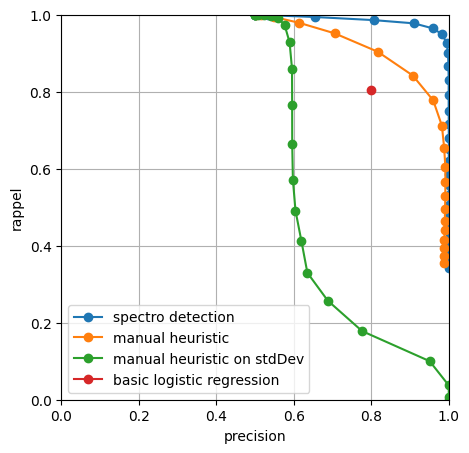

In [459]:
plt.figure(figsize=(5, 5))
for curve_dic in curve_dicts:
    plt.plot(curve_dic["precision"], curve_dic["rappel"],'-o', label=curve_dic["name"])

plt.legend()
plt.grid()
plt.xlabel("precision")
plt.ylabel("rappel")
plt.xlim(0, 1.)
plt.ylim(0., 1.)
plt.show()

In [483]:
# plt.plot(np.array(curve_dict_manual_spectro["precision"])**2 + np.array(curve_dict_manual_spectro["rappel"])**2)
